In [1]:
import sys
import argparse
import os
import numpy as np
from scipy.signal import get_window
from skimage.util import view_as_windows
from utilities.config_handler import get_config
from utilities.visualization import plot_spectogram
from utilities.learning import split_train_validation, train_model, predict_ae_error_vectors
from utilities.detection import detect_reconstruction_anomalies_median,plot_spectogram_anomalies
from utilities.preprocessing import  add_noise,load_fft_test_data ,load_fft_train_data,  reshape_to_blocks,persist_object\
    ,load_object,persist_val_stat, load_val_stat ,get_xhdr_sample_rate , compute_fft_train_data , load_raw_data , compute_fft_train_data \
, compute_fft_test_data,trim_iq_basic_block, complex2power
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from scipy.stats import entropy
from scipy.signal import welch,detrend
from scipy.fftpack import fft,rfft,fftshift,fft2
%matplotlib inline

Using TensorFlow backend.


In [2]:
normal_records = ['CELL_NORM_2', 'CELL_NORM_3', 'CELL_NORM_4']
anomal_records = ['CELL_SWP_18MHz_50us_0dB', \
          'CELL_SWP_18MHz_50us_10dB', 'CELL_SWP_18MHz_100us_0dB', 'CELL_SWP_18MHz_100us_10dB',
                 'CELL_SWP_45MHz_20us_0dB','CELL_SWP_45MHz_20us_10dB']

normal_path='iq_data/CELL/normal'
anomal_path='iq_data/CELL/anomal'

In [28]:
parser = argparse.ArgumentParser()
parser.prog = 'Spectrum Anomaly Detection'
parser.description = 'Use this command parser for training or testing the anomaly detector'
parser.add_argument('-m', '--mode', help='train or test mode', choices=['train', 'test'])
parser.add_argument('-d', '--data-dir', help='I/Q recording directory',nargs='?')
parser.add_argument('-w', '--weights-path', help='path for trained weights')


# sys.argv = "-m test -d -w model/baseline_cepstrum".split()
# sys.argv = "-m test -d iq_data/CELL/anomal/CELL_SWP_18MHz_50us_10dB -w model/baseline_cepstrum".split()
sys.argv = "-m train -d iq_data/CELL/normal/CELL_NORM_0 -w model/baseline_cepstrum".split()

namespace = parser.parse_args(sys.argv)
if not namespace.data_dir and namespace.mode == 'train':
    parser.error('the -d arg must be present when mode is train')
if not namespace.weights_path and namespace.mode == 'train':
    parser.error('the -w arg must be present when mode is train')

# if not namespace.data_dir and namespace.mode == 'test':
#     parser.error('the -d arg must be present when mode is test')

if not namespace.weights_path and namespace.mode == 'test':
    parser.error('the -w arg must be present when mode is test')
    
train = namespace.mode == 'train'

In [29]:
conf=get_config()
gpus = conf['gpus']
lr=conf['learning']['ae']['lr']
validation_split = conf['learning']['ae']['validation_split']
train_params = conf['learning']['ae']
rbw_set = conf['preprocessing']['ae']['rbw_set']
feature_names = conf['preprocessing']['ae']['feature_names']
fft_window_name = conf['preprocessing']['ae']['window']
basic_block_interval = conf['preprocessing']['basic_time']


median_kernel_size = 11
cepstrum_window_size = 512
cv_types = ['diag']

In [ ]:
def compute_frequency_spectrum(freq):
    num_samples = len(freq)
    freq = freq - np.mean(freq)
    window = get_window(fft_window_name, num_samples)
    fft_data = ((rfft(window*freq)))
    return fft_data

In [ ]:
def compute_welch_spectrum(freq):
    freq = freq - np.mean(freq)
    return welch(freq, nperseg=cepstrum_window_size , \
      noverlap=3*cepstrum_window_size//4 , scaling = 'spectrum',window='hann')[1]

In [ ]:
def train_cepstrum(data_dir,rbw):
    dataset_name = str.split(data_dir, '/')[1]
    recording_name = str.split(data_dir,'/')[-1]
    sample_rate = get_xhdr_sample_rate(data_dir)
    weights_dir = "_".join((dataset_name, str(rbw)))
    weights_path = os.path.join(namespace.weights_path, weights_dir)

    iq_data = load_raw_data(data_dir)
    iq_data = trim_iq_basic_block(iq_data , sample_rate)
    freqs, time, fft_train = compute_fft_train_data(iq_data,sample_rate,rbw,weights_path)
    cepstrum_train = np.abs(np.apply_along_axis(compute_welch_spectrum,0,fft_train))
    cepstrum_train = cepstrum_train[50:] # removing the zero frequency
    cepstrum_train_means_over_time = np.mean(cepstrum_train,axis=1)
    cepstrum_windows = view_as_windows(cepstrum_train_means_over_time,median_kernel_size,step=1)
    cepstrum_train_max = np.max(cepstrum_train_means_over_time)
    persist_object(cepstrum_train_max,os.path.join(weights_path,'cepstrum_max.pkl'))
    persist_object(cepstrum_train_means_over_time,os.path.join(weights_path,'cepstrum_train_means.pkl'))

In [ ]:
def test_cepstrum(data_dir,rbw):
    sample_rate = get_xhdr_sample_rate(data_dir)
    dataset_name = str.split(data_dir, '/')[1]
    recording_name = str.split(data_dir,'/')[-1]
    weights_dir = "_".join((dataset_name, str(rbw)))
    weights_path = os.path.join(namespace.weights_path, weights_dir)
    
    iq_data = load_raw_data(data_dir)
    iq_data = trim_iq_basic_block(iq_data , sample_rate)
    test_freqs, test_time, fft_test = compute_fft_test_data(iq_data,sample_rate,rbw,weights_path)
    cepstrum_test = np.abs(np.apply_along_axis(compute_welch_spectrum,0,fft_test))
    cepstrum_test = cepstrum_test[50:] # removing the zero frequency
    cepstrum_test_means_over_time = np.mean(cepstrum_test,axis=1)
    cepstrum_train_max = load_object(os.path.join(weights_path,'cepstrum_max.pkl'))
    cepstrum_train_means_over_time = load_object(os.path.join(weights_path,'cepstrum_train_means.pkl'))
    
    cepstrum_windows = view_as_windows(cepstrum_test_means_over_time,median_kernel_size,step=1)
    
    fig , (ax1 , ax2) = plt.subplots(1,2,sharey=True,figsize=(20,15))
    ax1.axhline(cepstrum_train_max)
    ax1.plot(cepstrum_test_means_over_time)
    ax1.set_title('Test cepstrum',fontsize=30)
    ax2.axhline(cepstrum_train_max)
    ax2.plot(cepstrum_train_means_over_time)
    ax2.set_title('Train cepstrum' , fontsize=30)
    plot_save_path = os.path.join(data_dir , "cepstrum_welch_window={}_interval={}.png".\
                                  format(cepstrum_window_size,basic_block_interval))
    plt.savefig(plot_save_path)

In [ ]:
if train:
    data_dir = namespace.data_dir
    for rbw in rbw_set:
        train_cepstrum(data_dir,rbw)
else:
    #Case we evaluate on set of fixed test sets
    if not namespace.data_dir:
        for r in normal_records:
            data_dir = os.path.join(normal_path, r)
            for rbw in rbw_set:
                test_cepstrum(data_dir,rbw)
                
        for r in anomal_records:
            data_dir = os.path.join(anomal_path,r)
            f_s = get_xhdr_sample_rate(data_dir)
            for rbw in rbw_set:
                test_cepstrum(data_dir,rbw)
    else:
        data_dir = namespace.data_dir
        assert len(data_dir) != 0
        for rbw in rbw_set:
            test_cepstrum(data_dir,rbw)

# Expriement

In [ ]:
def compute_welch_spectrum(freq):
    freq = freq - np.mean(freq)
    return welch(freq, nperseg=512 , \
      noverlap = 3*512//4, scaling = 'spectrum',window='hann')[1]

sweep_freq = fft_train[:,250]
fig , (ax1 , ax2) = plt.subplots(2,1,figsize=(10,10))
cepstrum_sample_plot_path = os.path.join(data_dir,"cepstrum_sample.png")
ax1.plot(sweep_freq)
ax1.set_title('Sweep frequency plot')
ax2.plot(np.abs(compute_welch_spectrum(sweep_freq)))
ax2.set_title('fft of frequency')
plt.show()

In [30]:
data_dir = namespace.data_dir
rbw=125e3
dataset_name = str.split(data_dir, '/')[1]
recording_name = str.split(data_dir,'/')[-1]
sample_rate = get_xhdr_sample_rate(data_dir)
weights_dir = "_".join((dataset_name, str(rbw)))
weights_path = os.path.join(namespace.weights_path, weights_dir)

iq_data = load_raw_data(data_dir)
iq_data = trim_iq_basic_block(iq_data , sample_rate)
freqs, time, fft_train = compute_fft_train_data(iq_data,sample_rate,rbw,weights_path)


In [31]:
freqs_mean = np.mean(fft_train , axis=0)
freqs_std = np.std(fft_train , axis=0)

fft_train , freqs_mean = np.broadcast_arrays(fft_train , freqs_mean)
fft_train , freqs_std = np.broadcast_arrays(fft_train , freqs_std)

fft_train_white = (fft_train - freqs_mean) / freqs_std

In [32]:
fft_train_white = fft_train_white - np.mean(fft_train_white)

In [33]:
fft_train_2d = np.abs(fftshift(fft2(fft_train_white)))

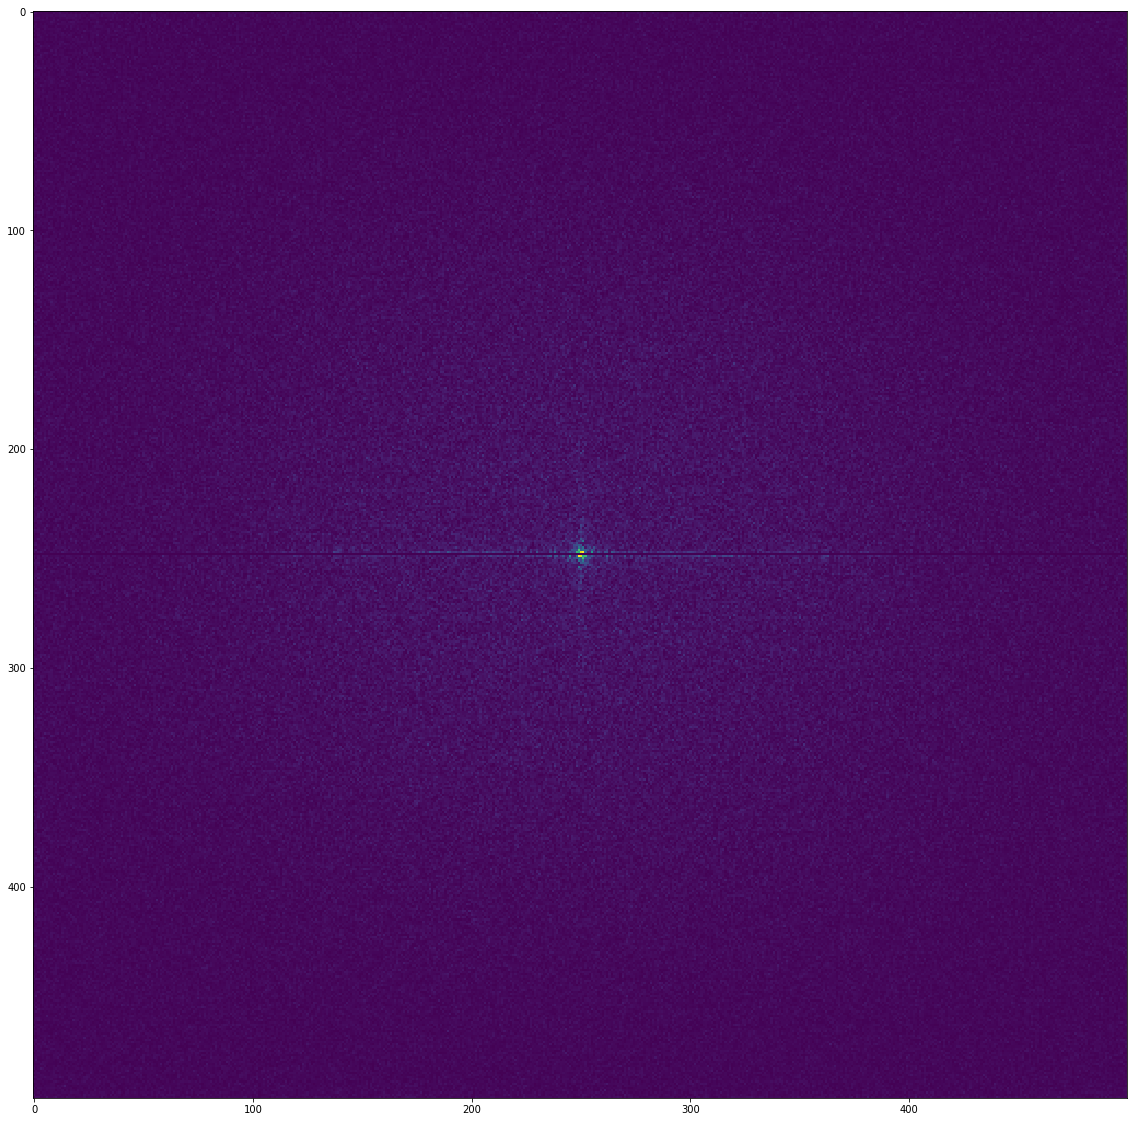

In [34]:
f = plt.figure(figsize=(20,20))
plt.imshow(fft_train_2d)

In [14]:
fft_train_2d.shape

(497, 500)

In [19]:
X, Y = np.meshgrid(range(fft_train_2d.shape[0]),range(fft_train_2d.shape[1]))

In [35]:
np.max(fft_train_2d)

13674.407

ValueError: shape mismatch: objects cannot be broadcast to a single shape

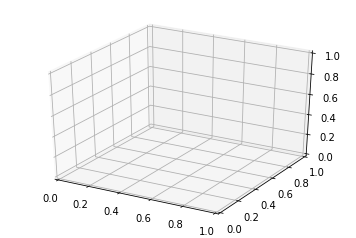

In [21]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,fft_train_2d)